# Cotton Plant Diesease Detector

# Description
## The dataset is organized into three folders (train, val and test) and contains subfolders for each image category . There are 2293 plant with and without diesease images (JPEG) and 4 categories.

# Problem Statement
- Detect Dieseases in Cotton Plant

# Constraints
- False Negative , is the biggest constraint for any botany based ML & DL based problems, we need to minimize this.
- Latancy is not the problem as tradition approches takes weeks.

# Benifits
- Predicting damage in eyes without using tradition or having domain expertise

## Importing Liberaries

In [1]:
import numpy as np
import pickle
import cv2
import seaborn as sb
from tqdm import tqdm
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Preparing some variables

In [2]:
train_dir = r'C:\Users\Lucifer MorningStar\Documents\train'
val_dir = r'C:\Users\Lucifer MorningStar\Documents\val'
test_dir = r'C:\Users\Lucifer MorningStar\Documents\test'

EPOCHS = 20
BATCH_SIZE = 256                          #Batch size
IMG_SIZE = (150, 150)                   # Image Size
learning_rate = 0.001
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE,)
val_dataset = image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE,)
test_dataset = image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

## Image Augumentation 

In [4]:
training_datagen = ImageDataGenerator(rescale = 1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,
      shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

testing_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Passing the images from datagenerator
train_generator = training_datagen.flow_from_directory(train_dir, target_size=(150,150), class_mode='categorical', batch_size=126)

# Passing Validation data in datagenator
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(150,150), class_mode='categorical', batch_size=126)

# Passing Test data in datagenator
test_generator = testing_datagen.flow_from_directory(test_dir, target_size=(150,150), class_mode='categorical', batch_size=126)

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


## EDA

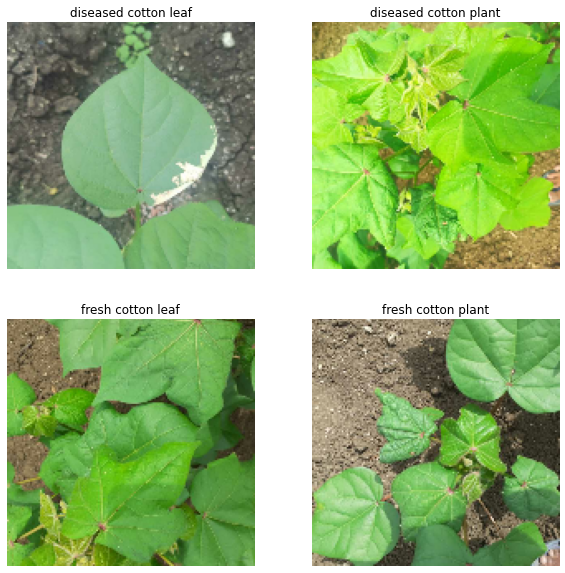

In [6]:
# Ploting  Diffrent Images
class_names = train_dataset.class_names 
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): 
    for i in range(len(class_names)):  
        ax = plt.subplot(2, 2, i + 1)   
        plt.imshow(images[i].numpy().astype("uint8"))   
        plt.title(class_names[i])  
        plt.axis("off")

## Barplot

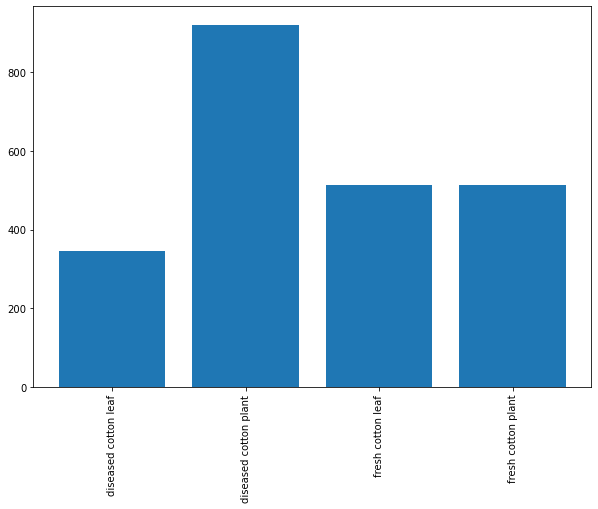

In [7]:
def plot(dirr): # Simple function to count all images in all three folders according to their classes
    image_list, label_list = [], []
    root_dir = listdir(dirr)
    plant_count = {}
    for plant_disease_folder in root_dir:
        count = 0
        plant_disease_image_list = listdir(f"{dirr}/{plant_disease_folder}/")
        for image in plant_disease_image_list:
            image_directory = f"{dirr}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                count += 1
        plant_count[plant_disease_folder] = count
    return plant_count

train_dat = plot(train_dir)
val_dat = plot(val_dir)
test_dat = plot(test_dir)

dat = val_dat, test_dat
for i in dat:
    keys = list(i.keys())
    for key in keys: 
        val = i.get(key)
        train_dat[key] += val
data  = train_dat

plt.figure(figsize=(10, 7))
plt.bar(x = list(data.keys()), height = list(data.values()))
plt.xticks(rotation = 90)
plt.show()

## PDF

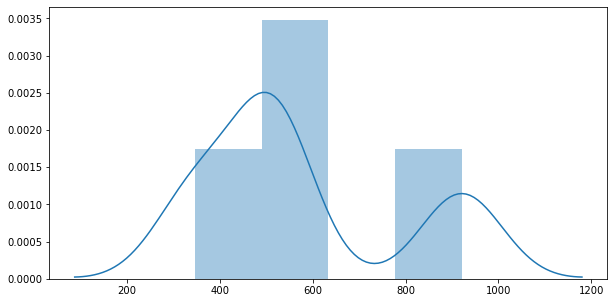

In [8]:
plt.figure(figsize=(10,5))
sb.distplot(list(data.values()))
plt.show()

## Transfer Learning/Creating Model

In [9]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(len(class_names), activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=learning_rate, decay=learning_rate / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"]) 

In [10]:
earlystoping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min',
  baseline=None, restore_best_weights=True)
history = model.fit(train_generator, epochs=40, steps_per_epoch=10,
                    validation_data = val_generator, verbose = 1, validation_steps=3, callbacks = [earlystoping])

Epoch 1/40
10/10 [==============================] - 18s 2s/step - loss: 1.8252 - accuracy: 0.4870 - val_loss: 1.0679 - val_accuracy: 0.6451
Epoch 2/40
10/10 [==============================] - 15s 1s/step - loss: 0.7918 - accuracy: 0.6845 - val_loss: 0.6710 - val_accuracy: 0.7377
Epoch 3/40
10/10 [==============================] - 16s 2s/step - loss: 0.5343 - accuracy: 0.7952 - val_loss: 0.5226 - val_accuracy: 0.8117
Epoch 4/40
10/10 [==============================] - 15s 1s/step - loss: 0.4717 - accuracy: 0.8243 - val_loss: 0.5039 - val_accuracy: 0.7963
Epoch 5/40
10/10 [==============================] - 15s 1s/step - loss: 0.4928 - accuracy: 0.8151 - val_loss: 0.4066 - val_accuracy: 0.8519
Epoch 6/40
10/10 [==============================] - 16s 2s/step - loss: 0.4245 - accuracy: 0.8476 - val_loss: 0.3647 - val_accuracy: 0.8673
Epoch 7/40
10/10 [==============================] - 16s 2s/step - loss: 0.3686 - accuracy: 0.8667 - val_loss: 0.3494 - val_accuracy: 0.8642
Epoch 8/40
10/10 [==

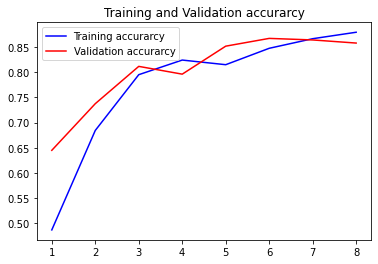

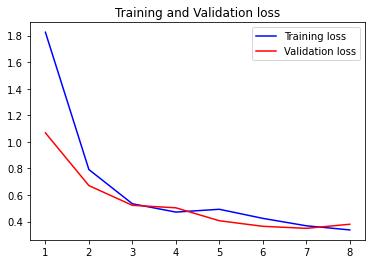

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Testing

In [20]:
print("Calculating model accuracy")
scores = model.evaluate(test_generator)
print(f"Test Accuracy: {scores[1]*100}")

Calculating model accuracy
1/1 [==============================] - 0s 997us/step - loss: 0.2013 - accuracy: 1.0000
Test Accuracy: 100.0
